## Exercise 2 HW: Introduction to Pytorch

As the first step, we need to install a suitable version of pytorch.
Go to https://pytorch.org/ and scroll down to the install section.
Pick the version fitting for your system and install it.
For example, if you do not have a GPU and you run Windows as your operating system:
```
conda activate idl23
conda install pytorch torchvision torchaudio cpuonly -c pytorch
```

Alternatively, you can use [Google Colab](https://colab.research.google.com/). 
This is a free service by Google that allows you to run Jupyter notebooks in their cloud. 
You can get GPU access by changing your runtime in top bar.
Their default environment has most standard packages installed, including pytorch.

## Polynomial Regression

Polynomial regression is slight more complex than linear regression.
Instead of just modeling the outcome as a linear combination of the features, polynomial regression models the output as a linear combination of polynomials of features.
In the case of a single feature, i.e., inputs $x \in \R$, the model is defined as:
$$f(x,w) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_q x^q.$$

In the more general case, where $x \in \R^p$, the model is defined as:
$$f(x,w) = w_0 + w_{11} x_1 + w_{12} x_1^2 + \dots + w_{1q} x_1^q + w_{21} x_2 + w_{22} x_2^2 + \dots + w_{2q} x_2^q + \dots = w_0 + \sum_{i=1}^p \sum_{j=1}^q w_{ij} x_i^j.$$

In this task, you implement a polynomial regression model in Pytorch and study the effects of the allowed complexity of the model on the quality of the fit to data.


1. Import pytorch and matplotlib.pyplot. The second library is commonly imported with the alias plt.

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

This cell defines synthetic data that your model will have to fit. The ground truth labels will follow a polynomial of degree 3.

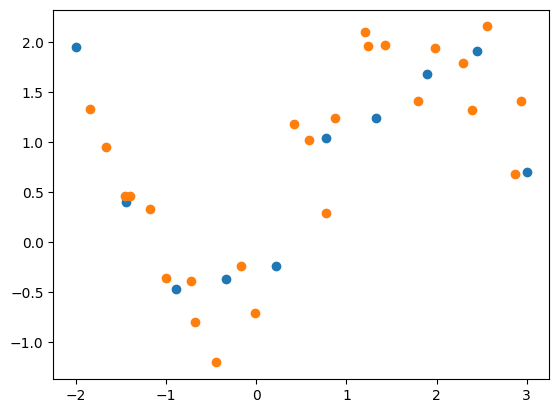

In [119]:
torch.manual_seed(123)
torch.use_deterministic_algorithms(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False

n_points = 10

def make_targets(x):
    return x + 0.5 * x**2 - 0.25 * x**3 + 0.4 * torch.randn_like(x)

x = torch.linspace(-2, 3, n_points).reshape(-1, 1)
y = make_targets(x)

x_val = torch.linspace(-2, 3, 25).reshape(-1, 1) + 0.1 * torch.randn((25, 1))
y_val = make_targets(x_val)

plt.scatter(x, y)
plt.scatter(x_val, y_val)

2. Implement a one-dimensional polynomial regression model.
    1. Create a class `PolyRegression` that inherits from `torch.nn.Module`.
    2. Create the `__init__` method. What is necessary to call inside that method for classes that inherit from `Module`? The method should have an integer argument that specifies the degree of the polynomial that will be fitted. The weights can be created with an `nn.Linear` layer, but you can also look at different approaches like using `nn.parameter.Parameter`.
    3. Create the forward method. It should implement the first equation of this notebook: $$f(x,w) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_q x^q.$$


Hint 1: torch.pow can be used to take a value to some power.

Hint 2: Pytorch documentation can help you if you are stuck.

In [120]:
class PolyRegression(torch.nn.Module):
    def __init__(self, degree):
        super(PolyRegression, self).__init__()
        self.degree = degree
        self.weights = torch.nn.Linear(degree + 1, 1)

    def forward(self, x):
        # Generate the polynomial features
        powers = torch.arange(self.degree + 1, dtype=torch.float32, device=x.device)
        x_powers = x ** powers.view(1, -1)

        # Compute the polynomial function
        y_pred = torch.sum(self.weights(x_powers), dim=1, keepdim=True)
        
        return y_pred

# Create a PolyRegression model with a polynomial degree of 3
model = PolyRegression(3)

# Generate input data 'x' (assuming 'x' is a tensor with the shape you expect)
x = torch.tensor([1.0, 2.0, 3.0]).reshape(-1, 1)

# Pass the input data through the model
out = model(x)

# Print the output
print(out)



tensor([[-0.4455],
        [-1.9732],
        [-5.2707]], grad_fn=<SumBackward1>)


3. Complete the following function that implements the training loop. It should implement the five general training steps.

In [121]:
def train_one_epoch(x, y, model, optimizer, loss_func):
    # Set the model in training mode
    model.train()
    
    # Forward pass
    predictions = model(x)
    
    # Calculate the loss
    loss = loss_func(predictions, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    return loss.item()  # Return the current loss as a float


4. Complete the following function that implements validation. Use the `torch.no_grad` function decorator or the `torch.no_grad` context manager inside this function to avoid making computations relevant for the gradient computation.

In [122]:
def eval(x, y, model, loss_func):
    # Set the model in evaluation mode
    model.eval()
    
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are computed during evaluation
        predictions = model(x)
    
    # Calculate the loss
    loss = loss_func(predictions, y)
    
    return loss.item()  # Return the current loss as a float


5. Combine the above functions to train a polynomial regression model with degree 3. The cell should instantiate a model, optimizer, and loss function, then iterate `n_epochs` many times over data to optimize the model. To ease optimization, use the `torch.optim.Adam` optimizer with `lr=5e-3`. To see whether you are overfitting, you can check the validation loss on `x_val, y_val` from time to time.

6. Name three hyperparameters you use in your code.

In [123]:
# Set a fixed random seed for reproducibility
torch.manual_seed(123)

# Define your training and validation data with the same number of features
# Assuming you have defined 'x', 'y', 'x_val', and 'y_val' correctly

# Hyperparameters
n_epochs = 100
learning_rate = 5e-3

# Create a PolyRegression model with a polynomial degree of 3
model = PolyRegression(3)

# Define the loss function (Mean Squared Error)
loss_func = nn.MSELoss()

# Define the optimizer (Adam optimizer with a learning rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(n_epochs):
    # Training phase
    model.train()
    current_loss = train_one_epoch(x, y, model, optimizer, loss_func)

    # Validation phase (optional, check validation loss from time to time)
    if (epoch + 1) % 10 == 0:
        validation_loss = eval(x_val, y_val, model, loss_func)
        print(f"Epoch [{epoch + 1}/{n_epochs}] - Training Loss: {current_loss:.4f} - Validation Loss: {validation_loss:.4f}")
    else:
        print(f"Epoch [{epoch + 1}/{n_epochs}] - Training Loss: {current_loss:.4f}")

# After training, you can use the trained model for predictions
# For example, you can use the model to predict 'y_pred' from 'x' with: y_pred = model(x)


RuntimeError: The size of tensor a (3) must match the size of tensor b (10) at non-singleton dimension 0

7. Visualize the resulting model with the following cell.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x.view(-1), y.view(-1), color="blue", label="Training data")
ax.scatter(x_val.view(-1), y_val.view(-1), color="orange", label="Validation data")

with torch.no_grad():
    x_plot = torch.linspace(x.min().item(), x.max().item(), 100).view(-1, 1)
    pred_plot = model(x_plot)
    ax.plot(x_plot, pred_plot, label="Model prediction", color="red")

ax.legend()

8. Revisit the model training.
    1. Try to train a model with much higher degree of the polynomial. You may need to change the number of epochs and the learning rate of the optimizer. How does the fit compare to the fit of the model with order 3?
    2. What happens if you train a model with degree 1 or 2? Are you over or underfitting; why?

9. How would you classify this task in the scheme of slide 6 in deck 2?